In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from tqdm import tqdm
simplefilter('ignore')
plt.style.use("ggplot")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color = '0.75',
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [2]:
cwd = Path.cwd() 

In [3]:
series_1 = pd.read_csv(cwd /'requests_1.csv', index_col = 0)
series_2 = pd.read_csv(cwd /'requests_2.csv', index_col = 0)
series_3 = pd.read_csv(cwd /'requests_3.csv', index_col = 0)

## Moving window method

Distance functions

In [7]:
from scipy.optimize import minimize

In [290]:
def Euclidean_distance(y_1, y_2):
    return (y_1 - y_2)**2
def Manhattan_distance(y_1, y_2):
    return abs(y_1 - y_2)
def Diffrence(y_pred, y):
    return y - y_pred

In [212]:
def moving_window(series, window_size, distance_function):
    max_distance = 0
    distance = 0
    distances = []
    index_max_distance = 0
    all_points = []
    
    moving_average = series.rolling(
    window = window_size,
    center = True).mean()
    for i in list(series.index):
        if not pd.isna(moving_average.loc[i]).values[0]:
            distance = distance_function(series.loc[i].values[0], moving_average.loc[i].values[0])
            distances.append(distance)
            all_points.append(series.loc[i].tolist()[0])
            # all_points.append(i)
            if distance > max_distance:
                max_distance = distance
                index_max_distance = i
    point = (index_max_distance, series.loc[index_max_distance].tolist()[0])
    return (max_distance, distances), (point, all_points)

In [213]:
def get_plot_distances(series, window_size, distance_function, plot_flag = True):
    distances, points = moving_window(series, window_size, distance_function)
    max_distance, all_distances = distances
    point, all_points = points
    if plot_flag:
        fig, ax = plt.subplots(1, 2, figsize = (15,7))
        ax[0].hist(all_distances)
        ax[0].set_title('Distances distribution')
        ax[1].plot(all_points, all_distances)
        ax[1].set_title('Distances')
        plt.show()
    else:
        return max_distance, point

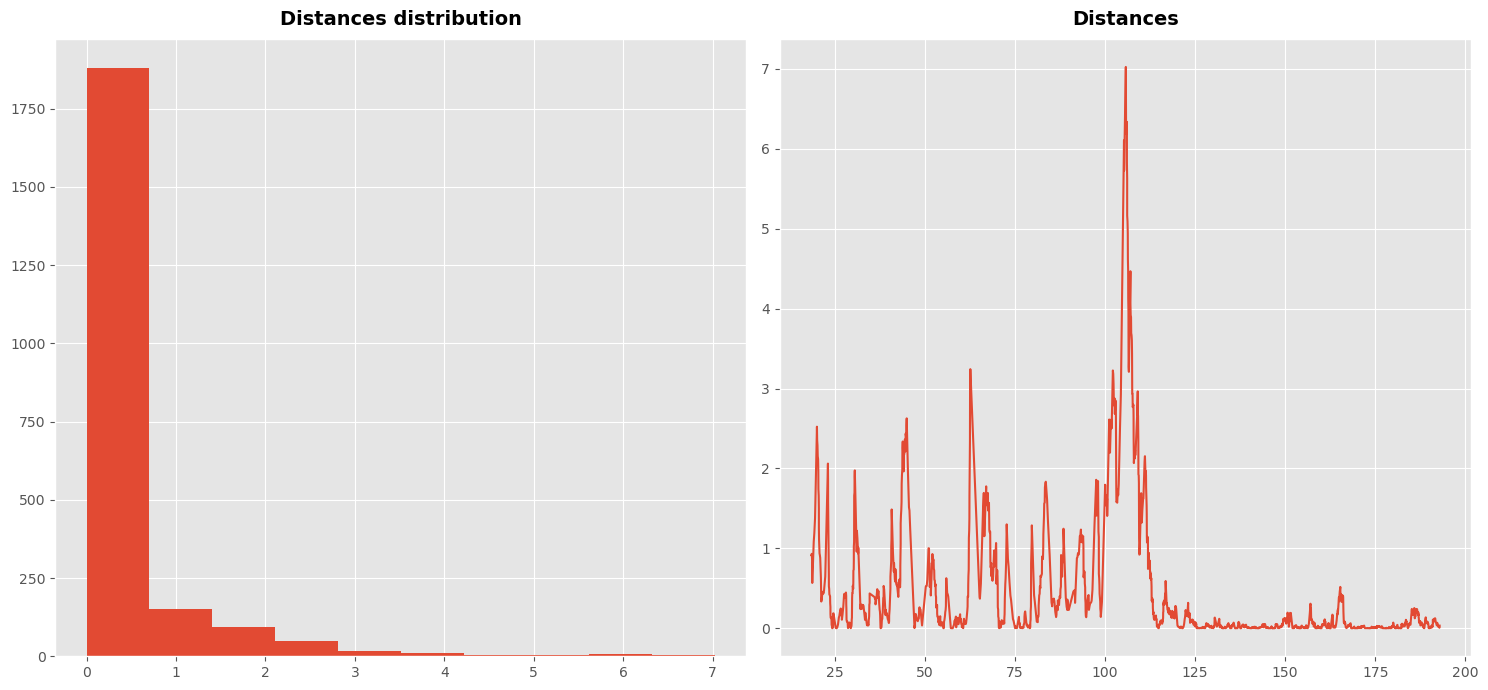

In [214]:
get_plot_distances(series_1, 250, Euclidean_distance)

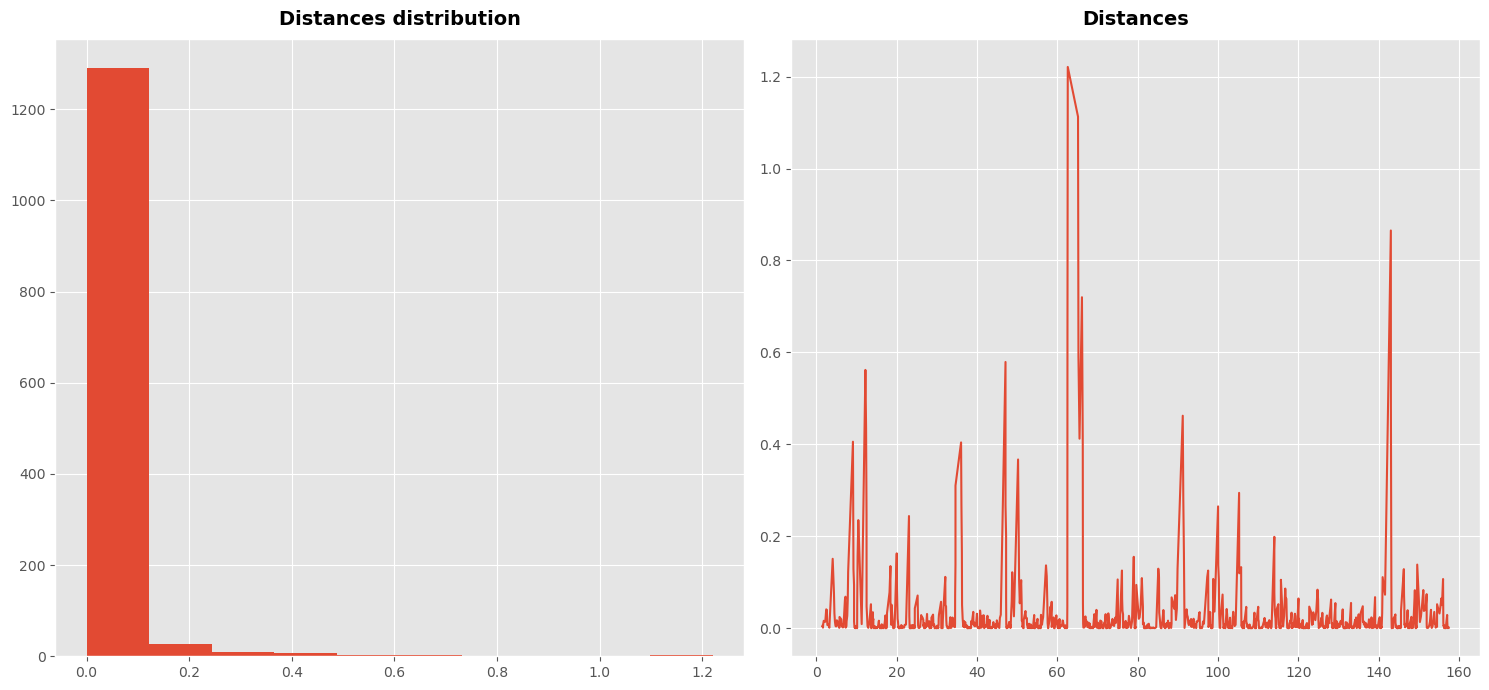

In [219]:
get_plot_distances(series_2, 10, Euclidean_distance)

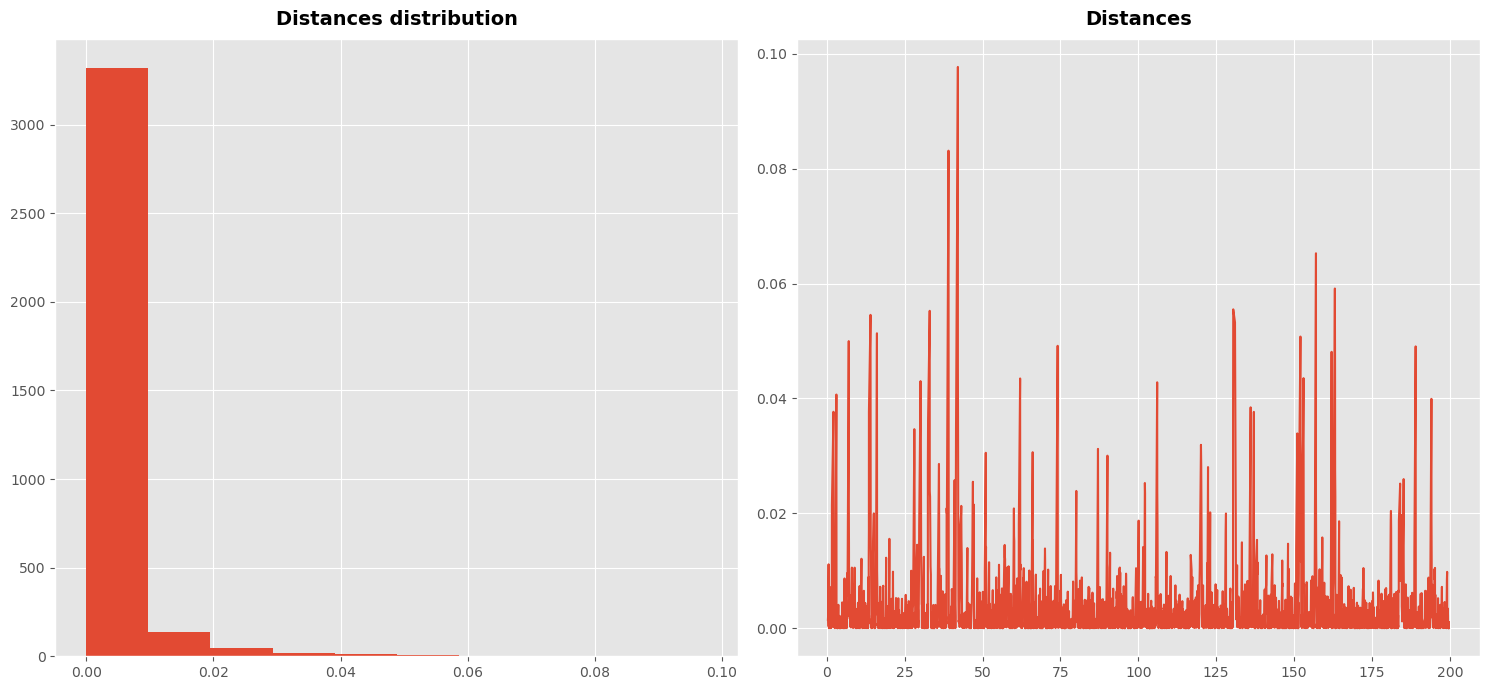

In [221]:
get_plot_distances(series_3, 10, Euclidean_distance)

Меняю параметры скользящего среднего и смотрю у каких точек чаще всего наибольшее расстояние

In [222]:
def get_set_points(series, params):
    ansvers = {}
    for distance_function in params['distance_function']:
        for window_size in tqdm(params['window_size']):
            _, points = moving_window(series, window_size, distance_function[1])
            point, _ = points
            if point not in ansvers:
                ansvers[point] = 0
            else:
                ansvers[point] += 1
    return ansvers

### Series_1

In [226]:
params = {'distance_function': [('Euclidean_distance', Euclidean_distance), ('Manhattan_distance', Manhattan_distance)],
          'window_size': np.arange(10, 500, 30)}
res = get_set_points(series_1, params)
print(f'point: {max(res, key=res.get)}, cnt_voices: {res[max(res, key=res.get)]}')

100%|██████████| 17/17 [00:05<00:00,  3.28it/s]

point: (840, 105.759687631), cnt_voices: 23


In [227]:
params = {'distance_function': [('Euclidean_distance', Euclidean_distance), ('Manhattan_distance', Manhattan_distance)],
          'window_size': np.arange(2, 300, 2)}
res = get_set_points(series_1.loc[700: 1200], params)
print(f'point: {max(res, key=res.get)}, cnt_voices: {res[max(res, key=res.get)]}')

100%|██████████| 149/149 [00:08<00:00, 17.83it/s]

point: (840, 105.759687631), cnt_voices: 225


### Series_2

In [228]:
max_dist, point = get_plot_distances(series_2, 100, Euclidean_distance, False)
print(point, max_dist)

(541, 62.599625176) 3.75411033561621


In [229]:
params = {'distance_function': [('Euclidean_distance', Euclidean_distance), ('Manhattan_distance', Manhattan_distance)],
          'window_size': np.arange(10, 600, 10)}
res = get_set_points(series_2, params)
print(f'point: {max(res, key=res.get)}, cnt_voices: {res[max(res, key=res.get)]}')

100%|██████████| 59/59 [00:09<00:00,  6.37it/s]

point: (840, 105.759687631), cnt_voices: 87


In [230]:
params = {'distance_function': [('Euclidean_distance', Euclidean_distance), ('Manhattan_distance', Manhattan_distance)],
          'window_size': np.arange(10, 500, 10)}
res = get_set_points(series_2.loc[:800], params)
print(f'point: {max(res, key=res.get)}, cnt_voices: {res[max(res, key=res.get)]}')

100%|██████████| 49/49 [00:04<00:00, 11.40it/s]

point: (541, 62.599625176), cnt_voices: 57


## Строим множетсво линейных регрессий на промежутках, считаем растояния и смотрим на максимальное

In [274]:
def get_lineregr(series, distance_functions, step_):
    line_reg_data = dict()
    distance_data = dict()

    for step in range(series.index[0], series.index[-1], step_):
        model = LinearRegression()
        X = np.array(series.loc[step:step+step_].index).reshape(-1,1)
        y = series.loc[step: step + step_]
        model.fit(X, y)
        y_pred = model.predict(X)
        coef_ = model.coef_
        intercept_= model.intercept_
        
        distance = distance_functions(y, y_pred)
        line_reg_data[step] = (coef_, intercept_, y_pred)
        distance_data[step] = distance
    return line_reg_data, distance_data
        


def get_plot_set_LinearRegression(line_reg_data, series):
    fig, ax = plt.subplots()
    ax.plot(series, '-', alpha = 1, linewidth = 0.1, color = 'black')
    for step in line_reg_data:
        X = np.arange(step, len(line_reg_data[step][2]) + step)
        y = line_reg_data[step][2]

        coef_ = line_reg_data[step][0]
        intercept_ = line_reg_data[step][1]
        
        ax.plot(X, y, label = f'linereg on [{step}, {len(line_reg_data[step][2]) + step}]')
        # ax.plot(np.arange(min(series.index), len(series)), (coef_*np.arange(min(series.index), len(series)) + intercept_).reshape(-1), '--', alpha = 0.6, color = 'grey')

    # ax.legend()

def plot_series(series, step, distance_functioin):
    line_reg_data, distance_data = get_lineregr(series, distance_functioin, step)
    get_plot_set_LinearRegression(line_reg_data, series)

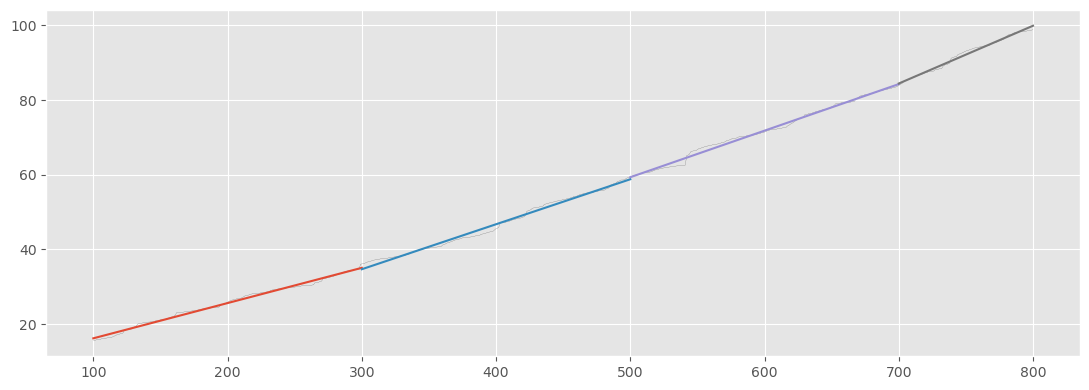

In [289]:
plot_series(series_2.loc[100:800], 200, Euclidean_distance)

In [327]:
def get_diffrence_data(series, step):
    line_reg_data, distance_data = get_lineregr(series, Manhattan_distance, step)
    res_data = pd.Series()
    for key in distance_data:
        res_data = pd.concat([res_data, distance_data[key]], axis = 0)
    res_data.drop(0, inplace = True, axis = 1)
    res_data = res_data[~res_data.index.duplicated(keep='first')]
    return res_data

<Axes: >

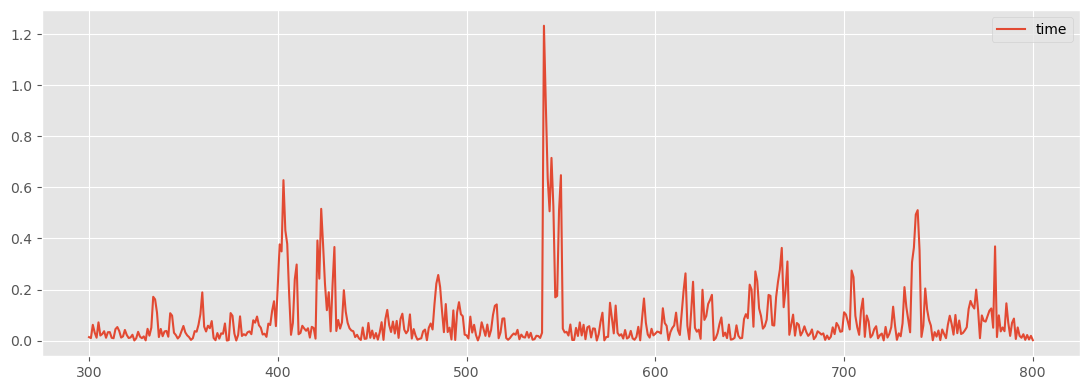

In [379]:
diffrence_data = get_diffrence_data(series_1.loc[300:800], 10)
diffrence_data.plot()

In [295]:
max_arr = []
for step in distance_data:
    max_temp = 0
    distances = np.array(distance_data[step]).reshape(-1)
    for i in range(len(distances)):
        if distances[i] > max_temp:
            max_ = distances[i]
            max_point = i + step
    max_arr.append((max_, max_point))
print(max_arr)
print(max(max_arr))

[(0.20645497735082993, 1000), (0.005648591529222126, 2000), (0.002168669215954998, 3000), (0.004898500447281289, 3553)]
(0.20645497735082993, 1000)


In [335]:
series_1_cuted= series_1.loc[500: 1200]

In [351]:
moving_average = series_1_cuted.rolling(
    window = 50).mean()
max_distance = 0

for i in range(min(series_1_cuted.index), max(series_1_cuted.index)):
    distance = Euclidean_distance(series_1_cuted.loc[i].values[0], moving_average.loc[i].values[0])
    if distance > max_distance:
        max_distance = distance
        index_max_distance = i
print(max_distance, index_max_distance)

24.209254856112974 744


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

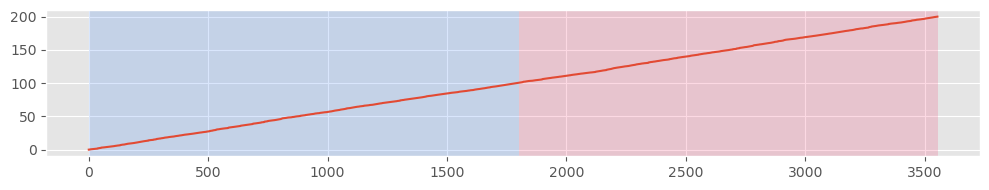

In [423]:
import numpy as np
import ruptures as rpt

# Выбор метода
# algo = rpt.Pelt(model="rbf").fit(series_1)
algo = rpt.Binseg(model="l2").fit(series_3)
result = algo.predict(n_bkps=1)

# Визуализация
rpt.display(series_3, result)

In [414]:
series_1_np

array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        2.46300000e+03, 2.46400000e+03, 2.46500000e+03],
       [1.07113864e+00, 1.10898811e+00, 1.15874196e+00, ...,
        1.99857754e+02, 1.99949665e+02, 1.99959272e+02]])

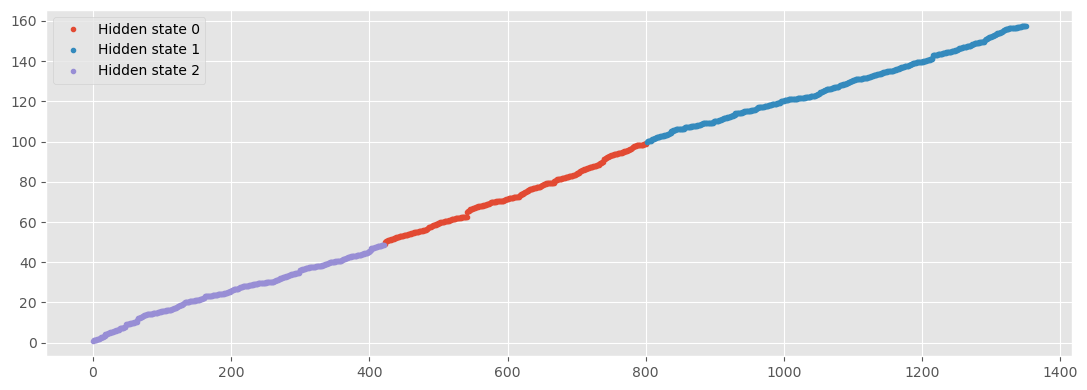

In [461]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(series_2)
hidden_states = model.predict(series_2)
plt.figure()
for i in range(model.n_components):
    state = (hidden_states == i)
    plt.plot(series_2[state], ".", label=f"Hidden state {i}")
plt.legend()
plt.show()


In [462]:
series_2[hidden_states == 2]

,time
0,1.071139
1,1.108988
2,1.158742
3,1.322638
4,1.341548
...,...
417,48.332476
418,48.388900
419,48.491940
420,48.647626
